In [1]:
from tool import *
import pandas as pd
import numpy as np

boards = ['Gossiping', 'C_Chat', 'WomenTalk', 'Baseball', 'HatePolitics', 'NBA']
print(boards)
df = pd.DataFrame(get_data(connect_db(), {'board': {'$in': boards}, }, projection={
    'raw_title':1, 'raw_text': 1, '_id': 0, 'board': 1
}))

df['raw_corpus'] = df['raw_title']+ ' ' + df['raw_text']
sp = SentenceProcessor()
# print(df.head())
corpus = [sp.cut_and_remove(title) for title in df['raw_corpus']]
board2id = {k:v for v, k in enumerate(boards)}
answer = [board2id[ans] for ans in df['board']]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.516 seconds.
Prefix dict has been built succesfully.


['Gossiping', 'C_Chat', 'WomenTalk', 'Baseball', 'HatePolitics', 'NBA']


In [2]:
from sklearn.model_selection import train_test_split


def data_split(X, y, test_size=0.2, random_state=40):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)
x_train, x_test, y_train, y_test = data_split(corpus, answer)

In [3]:
from gensim.models import Word2Vec


def build_word2vec_model(corpus, size=128, window=5, min_count=5):
    model = Word2Vec(corpus, size=size, window=window, negative=0, workers=4, min_count=min_count, hs=1, iter=5)
    model.save('models/w2v_size_{}_window_{}_min_count_{}.model'.format(size, window, min_count))
    return model

w2v_model = build_word2vec_model(x_train, 300, 5, 4)

In [4]:
word2idx = {"_PAD": 0} 
vocab_list = [(k, w2v_model.wv[k]) for k, v in w2v_model.wv.vocab.items()]
embeddings_matrix = np.zeros((len(w2v_model.wv.vocab.items()) + 1, w2v_model.vector_size))
for i in range(len(vocab_list)):
    word = vocab_list[i][0]
    word2idx[word] = i + 1
    embeddings_matrix[i + 1] = vocab_list[i][1]

In [5]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

token = Tokenizer()
token.word_index = word2idx
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)
x_train = pad_sequences(x_train, maxlen=200)
x_test = pad_sequences(x_test, maxlen=200)



In [6]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM


model = Sequential()
model.add(Embedding(embeddings_matrix.shape[0], embeddings_matrix.shape[1], weights=[embeddings_matrix], trainable=False))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(boards), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history_lstm = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test))

Using TensorFlow backend.
W0815 01:09:37.006949 139620787238720 deprecation_wrapper.py:119] From /home/user/miniconda3/envs/spider/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 01:09:37.019272 139620787238720 deprecation_wrapper.py:119] From /home/user/miniconda3/envs/spider/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 01:09:37.020705 139620787238720 deprecation_wrapper.py:119] From /home/user/miniconda3/envs/spider/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 01:09:37.025310 139620787238720 deprecation_wrapper.py:119] From /home/user/miniconda3/envs/spider/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         6198600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 6,435,534
Trainable params: 236,934
Non-trainable params: 6,198,600
_________________________________________________________________
Train on 4588 samples, validate on 1147 samples
Epoch 1/30
4588/4588 [==============================] - 15s 3ms/step - loss: 1

In [7]:
model.save('models/lstm.model')

In [8]:
from keras.layers import Bidirectional
from keras.layers import CuDNNLSTM


model = Sequential()
model.add(Embedding(embeddings_matrix.shape[0], embeddings_matrix.shape[1], weights=[embeddings_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(len(boards), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history_bilstm = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         6198600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         439296    
_________________________________________________________________
dense_3 (Dense)              (None, None, 128)         32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 6,935,502
Trainable params: 736,902
Non-trainable params: 6,198,600
____________________________________________________________

In [9]:
from keras.layers import GlobalMaxPooling1D
from keras.layers import CuDNNLSTM


model = Sequential()
model.add(Embedding(embeddings_matrix.shape[0], embeddings_matrix.shape[1], weights=[embeddings_matrix], trainable=False))
model.add(GlobalMaxPooling1D())
model.add(Dense(len(boards), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history_pooling = model.fit(x_train, y_train, batch_size=64, epochs=60, validation_data=(x_test, y_test))
model.save('pooling.model')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         6198600   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1806      
Total params: 6,200,406
Trainable params: 1,806
Non-trainable params: 6,198,600
_________________________________________________________________
Train on 4588 samples, validate on 1147 samples
Epoch 1/60
4588/4588 [==============================] - 1s 153us/step - loss: 1.6751 - acc: 0.3041 - val_loss: 1.4788 - val_acc: 0.4037
Epoch 2/60
4588/4588 [==============================] - 0s 29us/step - loss: 1.3434 - acc: 0.5194 - val_loss: 1.2344 - val_acc: 0.5571
Epoch 3/60
4588/4588 [==============================] - 0s 31us/step - lo

In [10]:
import matplotlib.pyplot as plt


def plot(history, title):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Model accuracy ({})'.format(title))
    plt.ylabel('Accuracy & loss')
    plt.xlabel('Epoch')
    plt.legend(['Train acc', 'Test acc', 'Train loss', 'Test loss'], loc='upper left')

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

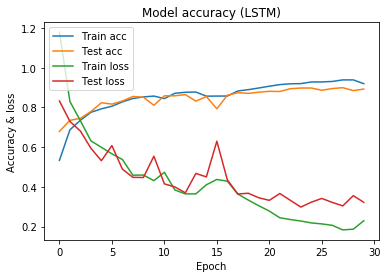

In [11]:
plot(history_lstm, 'LSTM')
plt.show()

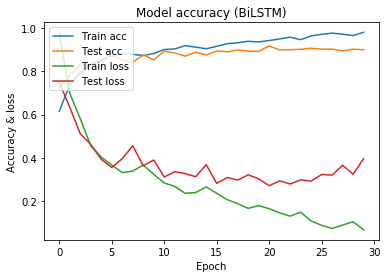

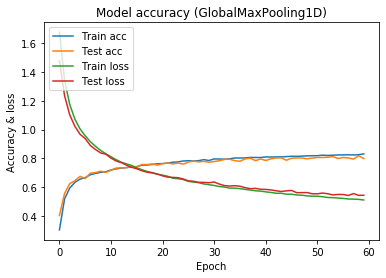

In [12]:
plot(history_bilstm, 'BiLSTM')
plt.show()

plot(history_pooling, 'GlobalMaxPooling1D')
plt.show()